## Калибровка вероятностей


### Зачем важна калибровка вероятностей?

Калибровка вероятности в контексте машинного обучения - это процесс коррекции вероятностей, возвращаемых моделью классификации, с целью сделать их более точными и интерпретируемыми. Это означает, что вероятности, предсказываемые моделью, должны соответствовать действительным частотам наступления событий. Калибровка позволяет улучшить точность и надежность вероятностных прогнозов модели, что важно для правильного принятия решений на их основе.

- Уверенность в прогнозах: Когда модель возвращает вероятности, они должны быть интерпретируемыми и точными. Калибровка помогает сделать вероятности более реалистичными и позволяет оценивать уверенность модели в своих прогнозах.
- Улучшение калибровки: Некалиброванные вероятности могут быть смещены и неадекватно оценивать вероятность события. Калибровка помогает исправить это смещение и сделать вероятности более точными.
- Улучшение метрик: Калиброванные вероятности позволяют улучшить метрики, такие как точность, площадь под ROC-кривой и log-loss.
- Принятие решений: Калиброванные вероятности легче интерпретировать и использовать для принятия решений. Это особенно важно в задачах, где безопасность и надежность критически важны.


Адаптировано из https://github.com/esokolov/ml-course-hse

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy.special import expit
from sklearn.impute import SimpleImputer

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

In [154]:
use_cols = [
    'Pclass', 'Sex', 'Age', 'Fare', 'SibSp',
    'Survived'
]

data = pd.read_csv('titanic.csv', usecols=use_cols)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,male,22.0,1,7.2500
1,1,1,female,38.0,1,71.2833
2,1,3,female,26.0,0,7.9250
3,1,1,female,35.0,1,53.1000
4,0,3,male,35.0,0,8.0500


In [155]:
result = pd.concat([data.isnull().sum(),data.isnull().mean()],axis=1)
result.rename(index=str,columns={0:'total missing',1:'proportion'})

,total missing,proportion
Survived,0,0.000000
Pclass,0,0.000000
Sex,0,0.000000
Age,177,0.198653
SibSp,0,0.000000
Fare,0,0.000000


Отмасштабируем данные и разделим на обучение и тест.

In [156]:
X_train, X_test, y_train, y_test = train_test_split(data[['Pclass', 'Sex', 'Age', 'Fare', 'SibSp']], data['Survived'], test_size=0.2, random_state=42)

X_train['Sex_oh'] = pd.get_dummies(X_train['Sex'], drop_first=True)
X_test['Sex_oh'] = pd.get_dummies(X_test['Sex'], drop_first=True)
X_train.drop(['Sex'], axis=1, inplace=True)
X_test.drop(['Sex'], axis=1, inplace=True)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X_train['Age'].values.reshape(-1, 1))
X_train['Age'] = imp_mean.transform(X_train['Age'].values.reshape(-1, 1))
X_test['Age']= imp_mean.transform(X_test['Age'].values.reshape(-1, 1))

scaler = StandardScaler().fit(X_train[['Age', 'Fare']])
X_train[['Age', 'Fare']] = scaler.transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

In [157]:
X_train.head()

,Pclass,Age,Fare,SibSp,Sex_oh
331,1,1.232263,-0.078684,0,1
733,2,-0.500482,-0.377145,0,1
382,3,0.192616,-0.474867,0,1
704,3,-0.269449,-0.476230,1,1
813,3,-1.809667,-0.025249,4,0


In [158]:
y_train.value_counts()

0    444
1    268
Name: Survived, dtype: int64

Посмотрим на баланс классов в данных.

In [159]:
print('Class balance:', y_train.mean())

Class balance: 0.37640449438202245


Классы сложно назвать сбалансированными. Обучим метод опорных векторов (SVC &mdash; Support Vector Classification) и логистическую регрессию, в качестве метрики возьмем ROC-AUC. В качестве скоров будем рассматривать выход `decision_function`, который пропорционален расстоянию до разделяющей гиперплоскости, взятого со знаком.

In [160]:
svc = LinearSVC(max_iter=100000, C=0.1).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
print('SVC ROC-AUC:', roc_auc_score(y_test, svc_pred))

SVC ROC-AUC: 0.8767052767052768


In [161]:
lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, lr_pred))

Logistic regression ROC-AUC: 0.88005148005148


ROC-AUC показывает, что мы практически идеально предсказываем целевую переменную. Посмотрим теперь на распределение скоров для тестовых объектов.

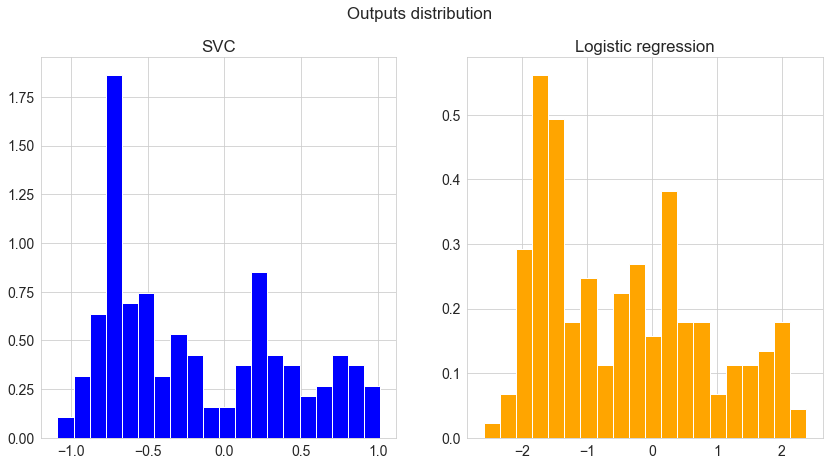

In [162]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

Мы видим, что скоры могут принимать любые вещественные значения. Но для оценивания вероятностей нам нужно загнать их в промежуток $[0, 1]$. Для логистической регрессии мы можем навесить сигмоиду, ведь модель и обучалась так, чтобы значение $\sigma\big(\langle w, x \rangle + b\big)$ приближало вероятности. Для SVC у нас нет такой опции, поэтому воспользуемся масштабированием через минимум-максимум.

In [163]:
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
lr_pred = lr.predict_proba(X_test)[:, 1]

Теперь мы можем построить калибровочные кривые.

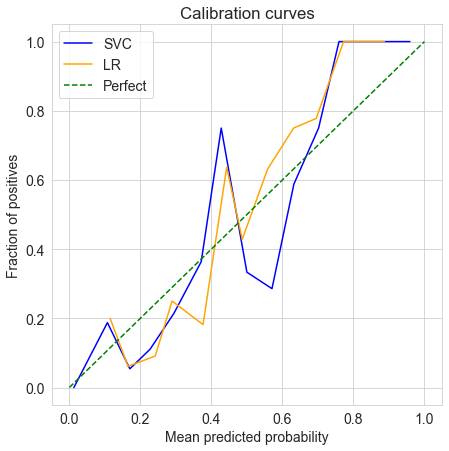

In [164]:
plt.figure(figsize=(7, 7))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

Мы видим, что кривая для логистической регрессии неплохо приближает диагональ. То же самое, увы, нельзя сказать про SVC. Попробуем откалибровать классификаторы и построить новые кривые.

### Методы калибровки

Наиболее популярными являются два метода калибровки &mdash; калибровка Платта (сигмоидная) и изотоническая регрессия. Оба этих метода реализованы в [`sklearn`](https://scikit-learn.org/stable/modules/calibration.html#calibration).

**Калибровка Платта**

Допустим, у нас есть обученный класификатор $b(x)$, который выдает уверенность (скор) в том, что $x$ относится к положительному классу. Метод приближает вероятность положительного класса с помощью сигмоидной функции:

$$
p\big(y = +1 \big| b(x)\big) = \frac{1}{1 + \exp (A \cdot b(x) + C)}
$$

Здесь обучаемыми параметрами являются $A, C \in \mathbb{R}$, их подбирают с помощью метода максимального правдоподобия (точно так же, как в логистической регрессии). Сделать это можно по кросс-валидации или на отложенной выборке. 

**Изотоническая регрессия**

Другой метод использует так называемую изотоническую функцию &mdash; кусочно-линейную возрастающую функцию $f: \mathbb{R} \rightarrow \mathbb{R}$. Функция подбирается так, чтобы минимизировать MSE по выборке:

$$
\frac{1}{\ell} \sum_{i=1}^\ell \big(y_i - f(b(x_i))\big)^2 \rightarrow \min_f
$$

Этот метод склонен к переобучению, поэтому его рекомендуется применять только для больших выборок.

Мы будем подбирать параметры калибровки с помощью кросс-валидации. Конечно, нет большого смысла калибровать логистическую регрессию, но мы проведем небольшой эксперимент.

In [165]:
sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.8776061776061777


In [166]:
isotonic_svc = CalibratedClassifierCV(svc, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_svc_pred = isotonic_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_svc_pred))

SVC ROC-AUC: 0.8732303732303732


In [167]:
sigmoid_lr = CalibratedClassifierCV(lr, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_lr_pred = sigmoid_lr.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, sigmoid_lr_pred))

Logistic regression ROC-AUC: 0.8806949806949808


In [168]:
isotonic_lr = CalibratedClassifierCV(lr, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_lr_pred = isotonic_lr.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, isotonic_lr_pred))

Logistic regression ROC-AUC: 0.8807593307593308


Построим новые калибровочные кривые:

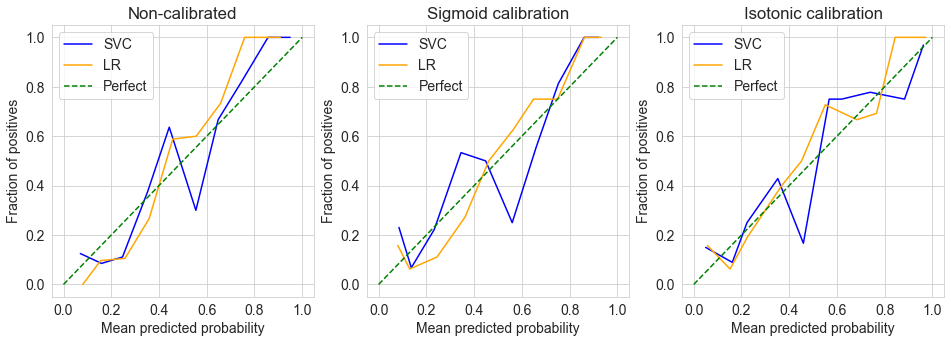

In [169]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=10)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=10)

axs[0].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[0].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[0].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[0].set_title('Non-calibrated')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, sigmoid_svc_pred, n_bins=10)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, sigmoid_lr_pred, n_bins=10)

axs[1].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[1].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[1].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[1].set_title('Sigmoid calibration')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, isotonic_svc_pred, n_bins=10)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, isotonic_lr_pred, n_bins=10)

axs[2].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[2].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[2].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[2].set_title('Isotonic calibration')

for ax in axs:
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.legend()

plt.show()

### Другие оценки калибровки

**Оценка Брайера (Brier Score)** - это метрика, используемая для оценки качества калибровки вероятностных прогнозов в задачах бинарной классификации. Она измеряет среднеквадратичное отклонение между предсказанными вероятностями и фактическими бинарными результатами (0 или 1). Метрика Brier Score стремится к нулю при идеальной калибровке, где предсказанные вероятности точно соответствуют частотам наступления событий.

$Brier Score = 1/N * \sum (P_i - O_i)^2$

N всего примеров.

$P_i$ предсказанная вероятность $i$.

$O_i$ бинарный результат примера $i$.


Предположим, что кто-то делает прогноз вероятности P дождя в течение определенного дня. Затем оценка Брайера вычисляется следующим образом:

- Если прогноз составляет 100% (P = 1) и идет дождь, то оценка Брайера равна 0, что является наилучшим достижимым результатом.
- Если прогноз составляет 100%, но дождя нет, то оценка Брайера равна 1, что является наихудшим достижимым результатом.
- Если прогноз составляет 70% (P = 0.70) и идет дождь, то оценка Брайера равна $(0.70−1)^2$ = 0.09.
- В отличие от этого, если прогноз составляет 70% (P = 0.70), но дождя нет, то оценка Брайера равна $(0.70−0)^2$ = 0.49.
- Аналогично, если прогноз составляет 30% (P = 0.30) и идет дождь, то оценка Брайера также равна $(0.30−1)^2$ = 0.49.
- Если прогноз составляет 50% (P = 0.50), то оценка Брайера равна $(0.50−1)^2$ = 0.25, независимо от того, идет дождь или нет.



**Логарифмическая потеря (Log Loss)**, также известная как кросс-энтропия, - это метрика, используемая для оценки качества вероятностных прогнозов в задачах бинарной или многоклассовой классификации. Она измеряет, насколько хорошо предсказанные вероятности соответствуют фактическим бинарным или категориальным результатам. Меньшие значения логарифмической потери указывают на более точные вероятностные прогнозы.